# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

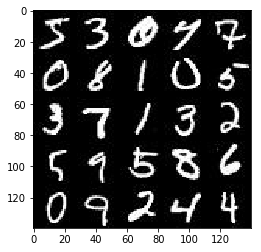

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

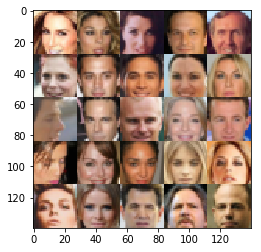

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
        
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    x = images
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        ## 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #saver = tf.train.Saver()

    steps = 0
    z_size = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                x = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                   

        #saver.save(sess, './checkpoints/generator.ckpt')

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.2994
Epoch 1/2... Discriminator Loss: 4.9057... Generator Loss: 0.0140
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 2.0863... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 1.2509
Epoch 1/2... Discriminator Loss: 1.6743... Generator Loss: 0.4014
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.5065


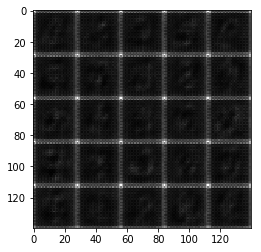

Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 1.0532
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 1.6950
Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 2.0099


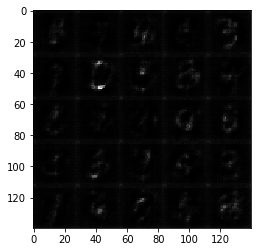

Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 2.0240
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 0.8918
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.6474
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 2.1846
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.2103
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 2.0395


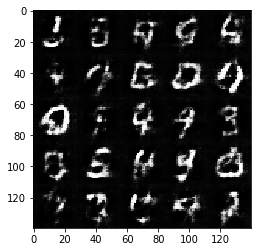

Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.7857
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.8435
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.7725
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.5420


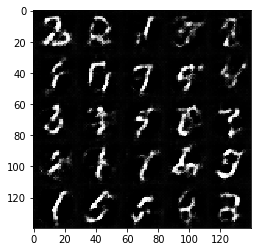

Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.4658
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 1.2235
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 2.1547
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.3441
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 1.1437


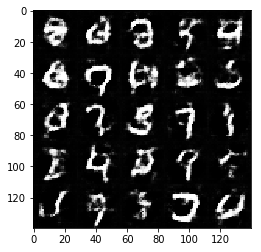

Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.0974
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 2.0757
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.3940
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 1.5987
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.5249... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.0325


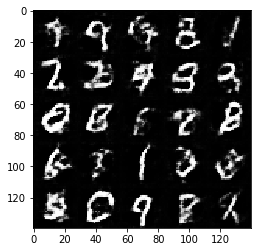

Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.4793
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.5254
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.0626


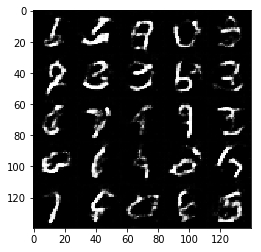

Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 0.5159
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 1.8927
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.3767
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.3798
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.7641


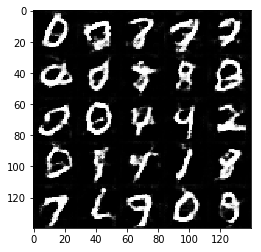

Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.3198
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.5911
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.1414
Epoch 1/2... Discriminator Loss: 3.2394... Generator Loss: 0.1021
Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 0.9152
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 1.4584
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.2481


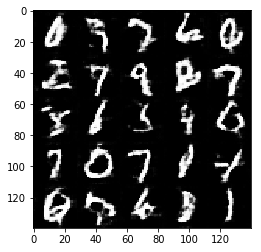

Epoch 1/2... Discriminator Loss: 1.0146... Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 1.7075
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.6669
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 2.4007
Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 1.1060
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.5587
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 0.8826


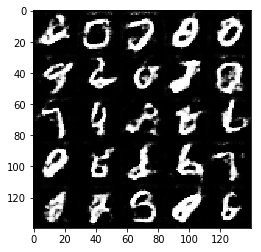

Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 2.5161... Generator Loss: 0.1776
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.1125
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 1.2670
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.0969
Epoch 2/2... Discriminator Loss: 1.7247... Generator Loss: 0.3699


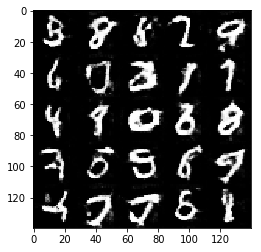

Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 1.3321
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 0.9568
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 0.7193
Epoch 2/2... Discriminator Loss: 1.9315... Generator Loss: 0.2894
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 0.7888


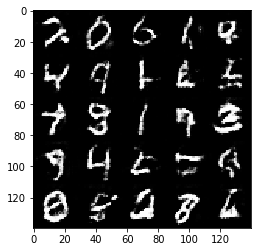

Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.5805
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.1543
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 1.2182
Epoch 2/2... Discriminator Loss: 1.8327... Generator Loss: 0.3443
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 1.7059


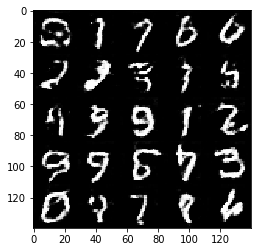

Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.3790
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 3.1131... Generator Loss: 0.1022
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.5632
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.3516
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 1.6151


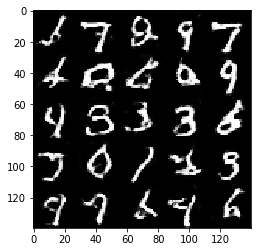

Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.9412
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.0645
Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 3.4189


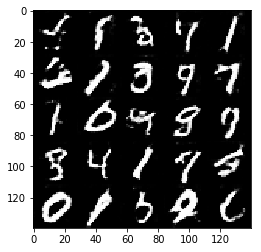

Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.4197
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.4822
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.5256
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.3010


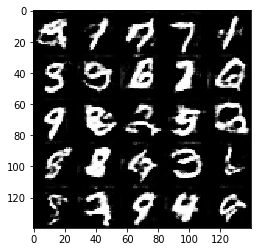

Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 2.3519... Generator Loss: 3.9841
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.2942
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.3975
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.4823


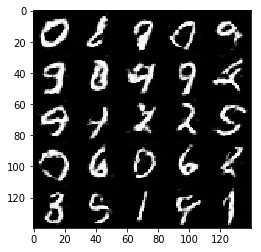

Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 2.9881
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.3825
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 1.1898
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 0.9338
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.6817


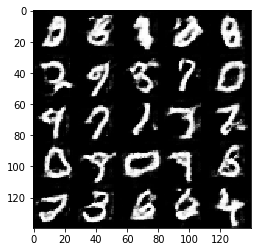

Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 1.0507
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.8717
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.0076


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.5371
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0405


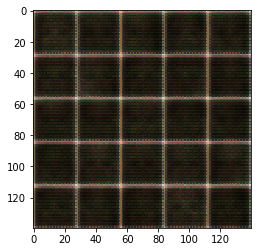

Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7277


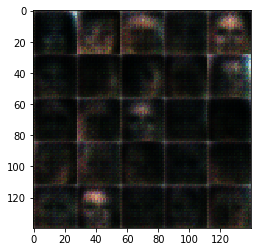

Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.1752


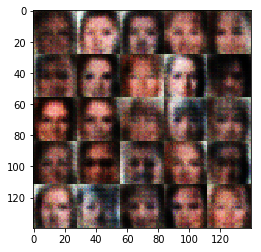

Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7502


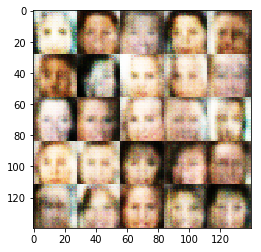

Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8089


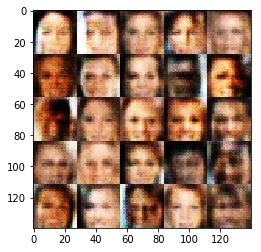

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7446


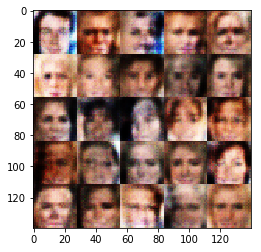

Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9213


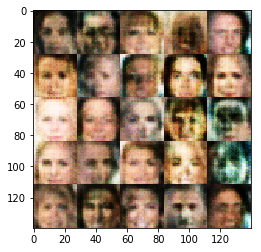

Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.4216


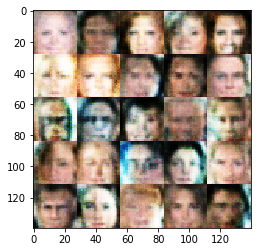

Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8511


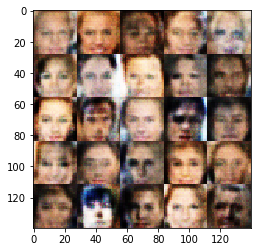

Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.6443


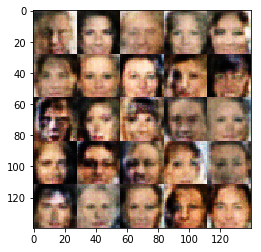

Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9022


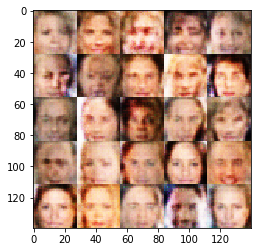

Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.2252


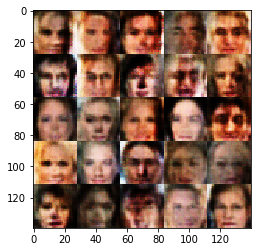

Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.7598... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 2.0735


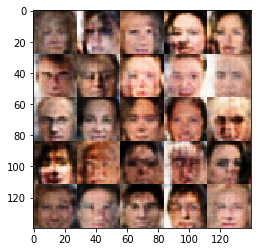

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9909


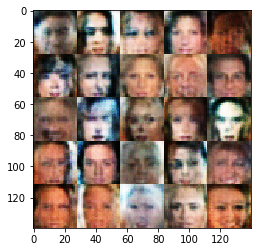

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7994


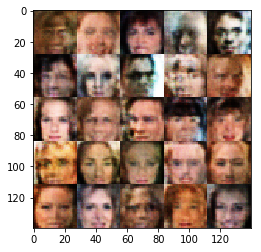

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.9552


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.